In [ ]:
#@title Connect to drive and install dependencies { vertical-output: true }

from google.colab import drive
drive.mount('/content/drive')

# If Colab runtime is not already GPU, switch to: Runtime > Change runtime type > T4/V100/A100 GPU
!nvidia-smi -L || true

# Core stack (Colab usually has torch/torchvision preinstalled; timm/torchmetrics we add)
!pip -q install timm torchmetrics

# Albumentations is convenient for NumPy-based augmentation
!pip -q install albumentations==1.4.7

!pip -q install tqdm




Mounted at /content/drive
GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-aa4e9797-dd46-56b0-3805-c024d49cb518)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 5.0 MB/s eta 0:00:00


In [34]:
#@title Config { vertical-output: true }

from dataclasses import dataclass
from pathlib import Path

@dataclass
class Cfg:
    data_dir: str = "/content/wildfire_dataset"
    train_sub: str = "train"
    val_sub:   str = "val"
    test_sub:  str = "test"    # optional
    use_test:  bool = True     # set False if you don't have test yet

    pos_name: str = "wildfire" # label 1
    neg_name: str = "other"    # label 0

    # We will *load MobileNet* as the pretrained backbone inside Student10k_ZKLite
    model_name: str = "mobilenetv3_small_075"  # try: 'mobilenetv3_large_100', 'tf_efficientnetv2_b0', etc.
    img_size: int = 128

    batch_size: int = 64
    epochs_stage1: int = 3   # warmup: head-only
    epochs_stage2: int = 15  # unfreeze & finetune
    epochs_stage3: int = 5   # EXTRA: fine-tune after mining FPs
    lr: float = 3e-4
    weight_decay: float = 1e-4
    num_workers: int = 2
    seed: int = 42

    pos_oversample: float = 1.5  # >1.0 oversamples positives; 1.0 disables

    # Mining configuration
    mine_precision_target: float = 0.95  # pick threshold to hit this precision if possible
    mine_max_save: int | None = 2000     # cap number of FP files copied (None = no cap)
    hard_neg_dirname: str = "other_hard" # subfolder under train/ to save mined FPs

    out_dir: str = "/content/checkpoints"
    best_name: str = "best.pt"

cfg = Cfg()
Path(cfg.out_dir).mkdir(parents=True, exist_ok=True)
cfg



Cfg(data_dir='/content/wildfire_dataset', train_sub='train', val_sub='val', test_sub='test', use_test=True, pos_name='wildfire', neg_name='other', model_name='mobilenetv3_small_075', img_size=128, batch_size=64, epochs_stage1=3, epochs_stage2=15, epochs_stage3=5, lr=0.0003, weight_decay=0.0001, num_workers=2, seed=42, pos_oversample=1.5, mine_precision_target=0.95, mine_max_save=2000, hard_neg_dirname='other_hard', out_dir='/content/checkpoints', best_name='best.pt')

In [ ]:
#@title Get Dataset { vertical-output: true }

!cp TO BE FILLED IN .
!unzip -q wildfire_dataset_with_places.zip



In [35]:
#@title Imports & Utilities { vertical-output: true }

import os, math, random, shutil, hashlib
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def cosine_factor(epoch, total_epochs):
    total_epochs = max(total_epochs, 1)
    return 0.5 * (1 + math.cos(math.pi * epoch / total_epochs))



Device: cuda


In [36]:
#@title NpyImageFolder dataset { vertical-output: true }

class NpyImageFolder(Dataset):
    """
    Directory structure:
      root/
        class_a/ *.npy
        class_b/ *.npy
    Each .npy holds ONE image: (H,W,C) or (C,H,W) or (H,W).
    Returns (tensor, target, idx) so we can mine by original file index.
    """
    def __init__(self, root, transform=None, min_bytes=128):
        self.root = Path(root)
        assert self.root.exists(), f"Missing folder: {self.root}"
        self.transform = transform

        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        assert self.classes, f"No class folders under {self.root}"
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}

        samples, skipped = [], []
        for cls in self.classes:
            for p in sorted((self.root/cls).rglob("*.npy")):
                # Skip macOS artifacts/hidden
                if any(part == "__MACOSX" for part in p.parts): continue
                if p.name.startswith("._"): continue
                if p.name == ".DS_Store": continue
                try:
                    if os.path.getsize(p) < min_bytes:
                        skipped.append(str(p)); continue
                except OSError:
                    skipped.append(str(p)); continue
                samples.append((str(p), self.class_to_idx[cls]))

        assert samples, f"No valid .npy files found under {self.root}"
        self.samples = samples
        if skipped:
            print(f"[NpyImageFolder] Skipped {len(skipped)} tiny/bad files. Example: {skipped[:5]}")
        print(f"Loaded {len(self.samples)} samples from {self.root} across {len(self.classes)} classes: {self.classes}")

    def __len__(self): return len(self.samples)

    def _to_tensor_3ch(self, arr: np.ndarray) -> torch.Tensor:
        a = arr
        if a.ndim == 2:
            a = a[..., None]
        if a.ndim == 3 and a.shape[0] in (1,3) and a.shape[2] not in (1,3):
            a = np.transpose(a, (1,2,0))  # (C,H,W)->(H,W,C)
        if a.shape[2] == 1:
            a = np.repeat(a, 3, axis=2)
        elif a.shape[2] > 3:
            a = a[..., :3]
        if np.issubdtype(a.dtype, np.floating):
            a = np.clip(a, 0, 1) if a.max() <= 1.0 else np.clip(a, 0, 255) / 255.0
        else:
            a = a.astype(np.float32) / 255.0
        return torch.from_numpy(np.ascontiguousarray(a)).permute(2,0,1)  # (3,H,W)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        try:
            arr = np.load(path, allow_pickle=False)
        except Exception as e:
            raise RuntimeError(f"Failed to load .npy: {path}. "
                               f"Likely macOS artifact/corrupt. Remove '._*' and '__MACOSX'. "
                               f"Original error: {repr(e)}")
        x = self._to_tensor_3ch(arr)
        if self.transform is not None:
            x = self.transform(x)
        # Return idx so we can map back to original file for mining
        return x, target, idx



In [37]:
#@title Transforms { vertical-output: true }

from torchvision import transforms as T

def make_transforms(img_size=64):
    train_tf = T.Compose([
        T.RandomResizedCrop(img_size, scale=(0.9, 1.0)),  # was (0.6,1.0)
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(p=0.2),
        T.ColorJitter(0.2, 0.2, 0.2, 0.05),
        T.ConvertImageDtype(torch.float32),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    val_tf = T.Compose([
        T.Resize(int(img_size*1.25), antialias=True),  # a tad more context
        T.CenterCrop(img_size),
        T.ConvertImageDtype(torch.float32),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return train_tf, val_tf

In [38]:
#@title Data Loaders (train / val / test grouped; same layout; test always present) { vertical-output: true }

set_seed(cfg.seed)
train_tf, val_tf = make_transforms(cfg.img_size)

# 1) Roots (train / val / test)
train_root = Path(cfg.data_dir) / cfg.train_sub
val_root   = Path(cfg.data_dir) / cfg.val_sub
test_root  = Path(cfg.data_dir) / cfg.test_sub
assert train_root.exists() and val_root.exists() and test_root.exists(), "Missing train/val/test folders."

# 2) Datasets (train / val / test)
train_ds_raw = NpyImageFolder(train_root, transform=train_tf)
val_ds_raw   = NpyImageFolder(val_root,   transform=val_tf)
test_ds_raw  = NpyImageFolder(test_root,  transform=val_tf)

# 3) Target map builder and maps (train / val / test)
def build_target_map(ds: NpyImageFolder):
    """
    Map dataset class indices to binary {0,1}.
    - cfg.pos_name -> 1
    - cfg.neg_name -> 0
    - all other classes -> 0 (e.g., 'other_hard', etc.)
    """
    cti = ds.class_to_idx
    assert cfg.pos_name in cti and cfg.neg_name in cti, \
        f"Expected class folders '{cfg.pos_name}' and '{cfg.neg_name}'. Found: {list(cti.keys())}"
    tm = {cti[cfg.pos_name]: 1, cti[cfg.neg_name]: 0}
    for k in cti.values():
        tm.setdefault(k, 0)
    return tm

target_map_train = build_target_map(train_ds_raw)
target_map_val   = build_target_map(val_ds_raw)
target_map_test  = build_target_map(test_ds_raw)

# 4) Imbalance stats & sampler (TRAIN ONLY)
labels_train = np.array([target_map_train.get(t, 0) for _, t in train_ds_raw.samples])
neg_cnt, pos_cnt = int((labels_train == 0).sum()), int((labels_train == 1).sum())
print(f"[Train] negatives={neg_cnt} positives={pos_cnt} total={len(train_ds_raw)}")

labels_tensor = torch.tensor(labels_train, dtype=torch.long)
class_counts  = torch.bincount(labels_tensor, minlength=2)
weights = torch.zeros_like(labels_tensor, dtype=torch.float)
for c in [0, 1]:
    w = 1.0 / max(int(class_counts[c].item()), 1)
    if c == 1: w *= cfg.pos_oversample
    weights[labels_tensor == c] = w
sampler = (WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)
           if cfg.pos_oversample != 1.0 else None)

# 5) Collate fns (train / val / test) — all return (x, y, idx)
def collate_and_remap_with_indices_factory(target_map_local):
    def _collate(batch):
        xs, ys_raw, idxs = zip(*batch)          # NpyImageFolder gives (x, y_raw, idx)
        xs   = torch.stack(xs, 0)
        ys   = torch.tensor([target_map_local.get(y, 0) for y in ys_raw], dtype=torch.long)
        idxs = torch.tensor(idxs, dtype=torch.long)
        return xs, ys, idxs
    return _collate

collate_train = collate_and_remap_with_indices_factory(target_map_train)
collate_val   = collate_and_remap_with_indices_factory(target_map_val)
collate_test  = collate_and_remap_with_indices_factory(target_map_test)

# 6) Loaders (train / val / test) — identical layout & ordering
train_loader = DataLoader(
    train_ds_raw,
    batch_size=cfg.batch_size,
    shuffle=(sampler is None),
    sampler=sampler,
    num_workers=cfg.num_workers,
    pin_memory=True,
    collate_fn=collate_train,
)

val_loader = DataLoader(
    val_ds_raw,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True,
    collate_fn=collate_val,
)

test_loader = DataLoader(
    test_ds_raw,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True,
    collate_fn=collate_test,
)
print(f"[Test] Loaded {len(test_ds_raw)} samples.")

# 7) Rebuild TRAIN helper (for mined FPs, keeps same layout)
def rebuild_train_loader():
    global train_ds_raw, train_loader, labels_train, labels_tensor, class_counts, weights, sampler
    global neg_cnt, pos_cnt, target_map_train, collate_train

    train_ds_raw     = NpyImageFolder(train_root, transform=train_tf)
    target_map_train = build_target_map(train_ds_raw)

    labels_train = np.array([target_map_train.get(t, 0) for _, t in train_ds_raw.samples])
    neg_cnt, pos_cnt = int((labels_train == 0).sum()), int((labels_train == 1).sum())

    labels_tensor = torch.tensor(labels_train, dtype=torch.long)
    class_counts  = torch.bincount(labels_tensor, minlength=2)
    weights = torch.zeros_like(labels_tensor, dtype=torch.float)
    for c in [0, 1]:
        w = 1.0 / max(int(class_counts[c].item()), 1)
        if c == 1: w *= cfg.pos_oversample
        weights[labels_tensor == c] = w
    sampler = (WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)
               if cfg.pos_oversample != 1.0 else None)

    collate_train = collate_and_remap_with_indices_factory(target_map_train)
    train_loader = DataLoader(
        train_ds_raw,
        batch_size=cfg.batch_size,
        shuffle=(sampler is None),
        sampler=sampler,
        num_workers=cfg.num_workers,
        pin_memory=True,
        collate_fn=collate_train,
    )
    print(f"[Rebuild] TRAIN with mined FPs → negatives={int((labels_train==0).sum())} "
          f"positives={int((labels_train==1).sum())} total={len(train_ds_raw)}")


Loaded 9787 samples from /content/wildfire_dataset/train across 2 classes: ['other', 'wildfire']
Loaded 1200 samples from /content/wildfire_dataset/val across 2 classes: ['other', 'wildfire']
Loaded 1310 samples from /content/wildfire_dataset/test across 2 classes: ['other', 'wildfire']
[Train] negatives=9107 positives=680 total=9787
[Test] Loaded 1310 samples.


In [39]:
#@title Model Tester { vertical-output: true }

import matplotlib.pyplot as plt

def _confusion_counts(y_true_np: np.ndarray, probs_np: np.ndarray, thresh: float):
    pred = probs_np >= thresh
    y = y_true_np.astype(bool)
    tp = int((pred &  y).sum())
    fp = int((pred & ~y).sum())
    tn = int((~pred & ~y).sum())
    fn = int((~pred &  y).sum())
    return tp, fp, tn, fn

def evaluate_bce_logits(model: nn.Module, loader, threshold:float=0.5):
    model.eval()
    auroc = BinaryAUROC().to(device)
    ap    = BinaryAveragePrecision().to(device)
    total, correct = 0, 0
    from torch.nn.functional import sigmoid
    with torch.no_grad():
        for batch in loader:
            x, y = _iter_loader_yields_imgs_labels(batch)
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).float()
            logits = model(x).view(-1)
            probs  = sigmoid(logits)
            preds  = (probs >= threshold).float()
            correct += (preds == y).sum().item()
            total   += y.numel()
            auroc.update(probs, y.int())
            ap.update(probs, y.int())
    return {
        "acc": correct / max(1, total),
        "auroc": auroc.compute().item(),
        "ap": ap.compute().item()
    }

def find_threshold_for_precision(model, loader):
    """
    Sweep thresholds to find the smallest threshold that achieves >= target precision.
    Returns (best_threshold, achieved_precision, recall_at_best).
    """
    model.eval()
    probs_all, y_all = [], []
    with torch.no_grad():
        for batch in loader:
            # works for (x,y) or (x,y,idx)
            if len(batch) == 2:
                x, y = batch
            else:
                x, y, _ = batch
            x = x.to(device)
            y = y.to(device).float()
            logits = model(x).view(-1)
            probs_all.append(sigmoid(logits).cpu())
            y_all.append(y.cpu())
    probs = torch.cat(probs_all).numpy()
    y     = torch.cat(y_all).numpy().astype(int)

    thresholds = np.linspace(0.0, 1.0, 501)
    best_t, best_prec, best_rec = 0.5, 0.0, 0.0
    for t in thresholds:
        pred = probs >= t
        tp = (pred & (y==1)).sum()
        fp = (pred & (y==0)).sum()
        fn = ((~pred) & (y==1)).sum()
        prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp / (tp+fn) if (tp+fn)>0 else 0.0
        if prec >= best_prec:
            best_t, best_prec, best_rec = float(t), float(prec), float(rec)
    return best_t, best_prec, best_rec

def plot_confusion_matrix(tp:int, fp:int, tn:int, fn:int,
                          title:str="Confusion Matrix",
                          cmap:str="Purples",
                          normalize:str="row"):
    mat = np.array([[tn, fp],
                    [fn, tp]], dtype=int)
    disp = mat.copy()

    if normalize in ("row", "col", "all"):
        if normalize == "row":
            denom = disp.sum(axis=1, keepdims=True)
        elif normalize == "col":
            denom = disp.sum(axis=0, keepdims=True)
        else:  # 'all'
            denom = disp.sum()
        denom = np.where(denom == 0, 1.0, denom)
        disp = 0.8 * disp / denom

    fig = plt.figure(figsize=(4, 4))
    ax = plt.gca()
    vmin, vmax = (0.0, 1.0) if normalize in ("row", "col", "all") else (None, None)
    im = ax.imshow(disp, cmap=cmap, vmin=vmin, vmax=vmax)
    # ticks/labels
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred Negative","Pred Wildfire"])
    ax.set_yticklabels(["True Negative","True Wildfire"])
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Ground Truth")
    ax.set_title(title + ("" if normalize=="none" else f" (norm={normalize})"))
    # annotate
    for i in range(2):
        for j in range(2):
                ax.text(j, i, f"{int(mat[i,j])}", ha="center", va="center")
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


def test_models(model, loader):
    # Collect all logits/probs and labels once
    model.to("cuda")
    probs_all, y_all = [], []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 2:
                x, y = batch
            else:
                x, y, _ = batch
            x = x.to(device)
            y = y.to(device).float()
            logits = model(x).view(-1)
            probs_all.append(sigmoid(logits).cpu())
            y_all.append(y.cpu())

    probs = torch.cat(probs_all)
    y     = torch.cat(y_all)
    probs_np = probs.numpy()
    y_np     = y.numpy().astype(int)

    # Use your existing evaluator for AUROC/AP/Acc @ 0.5
    metrics_at_05 = evaluate_bce_logits(model, loader, threshold=0.5)
    t_prec, p_prec, r_prec = find_threshold_for_precision(model, loader)
    metrics_at_threshold = evaluate_bce_logits(model, loader, threshold=t_prec)

    # Confusion matrices
    tp05, fp05, tn05, fn05 = _confusion_counts(y_np, probs_np, 0.5)
    tpp, fpp, tnp, fnp     = _confusion_counts(y_np, probs_np, t_prec)

    print(f"[Eval @0.5] ACC={metrics_at_05['acc']:.4f} AUROC={metrics_at_05['auroc']:.4f} PR-AUC={metrics_at_05['ap']:.4f}")
    plot_confusion_matrix(tp05, fp05, tn05, fn05, title=f"Confusion @0.5")

    print(f"[Eval @{t_prec:.3f}] ACC={metrics_at_threshold['acc']:.4f} AUROC={metrics_at_threshold['auroc']:.4f} PR-AUC={metrics_at_threshold['ap']:.4f}")
    plot_confusion_matrix(tpp, fpp, tnp, fnp, title=f"Confusion @{t_prec:.3f}")

    # Keep original return contract
    return metrics_at_05, t_prec, metrics_at_threshold


In [40]:
#@title Teacher Model Architecture { vertical-output: true }

import timm
import torch
import torch.nn as nn

class TeacherModel(nn.Module):
    """
    Large pretrained teacher for 64x64 RGB binary classification.
    Uses a TIMM backbone and outputs a SINGLE logit (B,1).
    """
    def __init__(self, backbone:str="convnext_base.fb_in22k_ft_in1k", pretrained:bool=True):
        super().__init__()
        # Any TIMM backbone works; keep num_classes=1 for single-logit BCE
        self.net = timm.create_model(
            backbone,
            pretrained=pretrained,
            in_chans=3,
            num_classes=1,        # single logit
            global_pool="avg"     # GAP -> linear
        )

    def forward(self, x):
        out = self.net(x)         # (B,1)
        if out.ndim == 1:
            out = out[:, None]
        return out

def count_trainable_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

teacher = TeacherModel()
print(f"[Teacher] params (trainable) = {count_trainable_params(teacher):,}")
teacher.to(device);


[Teacher] params (trainable) = 87,567,489


In [41]:
#@title Teacher training architecture (2-stage: freeze head→full finetune) { vertical-output: true }

import math
from torch.optim import AdamW
from torch.nn.functional import sigmoid
from torch.amp import GradScaler, autocast
from torchmetrics.classification import BinaryAUROC, BinaryAveragePrecision

def compute_pos_weight_from_counts(pos_cnt:int, neg_cnt:int) -> torch.Tensor:
    # pos_weight = N_neg / N_pos
    pw = (neg_cnt / max(1, pos_cnt))
    return torch.tensor([pw], dtype=torch.float32, device=device)

def _iter_loader_yields_imgs_labels(batch):
    # Train collate returns (x,y); Val collate returns (x,y,idx)
    if len(batch) == 2:
        xs, ys = batch
        return xs, ys
    elif len(batch) == 3:
        xs, ys, _ = batch
        return xs, ys
    else:
        raise ValueError("Unexpected batch format.")

def freeze_backbone_timm(m: nn.Module, train_head_only: bool = True):
    """
    For common TIMM models, last classifier params contain 'fc' or 'classifier'.
    We'll mark ONLY classifier params trainable during stage-1.
    """
    # first freeze all
    for p in m.parameters(): p.requires_grad = False
    # then unfreeze classifier/head
    head_names = []
    for n, p in m.named_parameters():
        if any(k in n for k in ["fc.", "classifier.", "head.", "heads."]):
            p.requires_grad = True
            head_names.append(n)
    if not head_names:
        # generic fallback: unfreeze the very last linear layer
        last_linear = None
        for mod in reversed(list(m.modules())):
            if isinstance(mod, nn.Linear):
                last_linear = mod
                break
        if last_linear is not None:
            for p in last_linear.parameters(): p.requires_grad = True

def train_teacher(
    model: nn.Module,
    train_loader,
    val_loader,
    epochs_stage1:int = None,   # default from cfg
    epochs_stage2:int = None,   # default from cfg
    base_lr: float = None,      # default from cfg
    weight_decay: float = None  # default from cfg
):
    model.to(device)
    epochs_stage1 = epochs_stage1 or cfg.epochs_stage1
    epochs_stage2 = epochs_stage2 or cfg.epochs_stage2
    base_lr       = base_lr or cfg.lr
    weight_decay  = weight_decay if weight_decay is not None else cfg.weight_decay

    # class imbalance (use counts from earlier cell)
    pos_weight = compute_pos_weight_from_counts(pos_cnt, neg_cnt)
    criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

    # ----------------
    # Stage 1: head-only
    # ----------------
    freeze_backbone_timm(model.net, train_head_only=True)
    opt = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=base_lr, weight_decay=weight_decay)

    print(f"[Teacher][Stage1] trainable params: {count_trainable_params(model):,}")
    for e in range(1, epochs_stage1+1):
        model.train()
        running = 0.0; seen = 0
        for batch in train_loader:
            x, y = _iter_loader_yields_imgs_labels(batch)
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).float()
            opt.zero_grad(set_to_none=True)
            with autocast("cuda", enabled=torch.cuda.is_available()):
                logits = model(x).view(-1)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            running += loss.item()*x.size(0); seen += x.size(0)

        val = evaluate_bce_logits(model, val_loader)
        print(f"[Teacher][S1][{e}/{epochs_stage1}] loss={running/max(1,seen):.4f} "
              f"val_acc={val['acc']:.4f} auroc={val['auroc']:.4f} ap={val['ap']:.4f}")

    # ----------------
    # Stage 2: unfreeze whole net (cosine LR decay)
    # ----------------
    for p in model.parameters(): p.requires_grad = True
    print(f"[Teacher][Stage2] trainable params: {count_trainable_params(model):,}")

    # two param groups (backbone lower LR, head higher LR)
    head_params, backbone_params = [], []
    for n, p in model.named_parameters():
        (head_params if any(k in n for k in ["fc.", "classifier.", "head.", "heads."]) else backbone_params).append(p)
    opt = AdamW([
        {"params": backbone_params, "lr": base_lr * 0.3},
        {"params": head_params,     "lr": base_lr},
    ], weight_decay=weight_decay)

    best_ap = -1.0
    best_path = str(Path(cfg.out_dir)/"best_teacher.pt")

    for e in range(1, epochs_stage2+1):
        model.train()
        running = 0.0; seen = 0
        lr_factor = 0.5 * (1 + math.cos(math.pi * (e-1) / max(1, epochs_stage2-1)))
        for pg in opt.param_groups:
            base = base_lr if pg is opt.param_groups[1] else base_lr*0.3
            pg["lr"] = base * lr_factor

        for batch in train_loader:
            x, y = _iter_loader_yields_imgs_labels(batch)
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).float()
            opt.zero_grad(set_to_none=True)
            with autocast("cuda", enabled=torch.cuda.is_available()):
                logits = model(x).view(-1)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update()
            running += loss.item()*x.size(0); seen += x.size(0)

        val = evaluate_bce_logits(model, val_loader)
        print(f"[Teacher][S2][{e}/{epochs_stage2}] loss={running/max(1,seen):.4f} "
              f"val_acc={val['acc']:.4f} auroc={val['auroc']:.4f} PR-AUC={val['ap']:.4f}")

        # save best by AP (PR-AUC) — good for imbalance
        if val["ap"] > best_ap:
            best_ap = val["ap"]
            torch.save({"model": model.state_dict(), "ap": best_ap}, best_path)
            print(f"  ↳ Saved best teacher to {best_path} (PR-AUC={best_ap:.4f})")

    return model


[Teacher][Stage1] trainable params: 3,073
[Teacher][S1][1/3] loss=1.6206 val_acc=0.3717 auroc=0.9686 ap=0.7455
[Teacher][S1][2/3] loss=0.7644 val_acc=0.5333 auroc=0.9762 ap=0.7958
[Teacher][S1][3/3] loss=0.6683 val_acc=0.6392 auroc=0.9793 ap=0.8159
[Teacher][Stage2] trainable params: 87,567,489
[Teacher][S2][1/15] loss=0.3568 val_acc=0.9308 auroc=0.9931 PR-AUC=0.9258
  ↳ Saved best teacher to /content/checkpoints/best_teacher.pt (PR-AUC=0.9258)
[Teacher][S2][2/15] loss=0.2508 val_acc=0.9433 auroc=0.9954 PR-AUC=0.9606
  ↳ Saved best teacher to /content/checkpoints/best_teacher.pt (PR-AUC=0.9606)
[Teacher][S2][3/15] loss=0.1487 val_acc=0.9600 auroc=0.9957 PR-AUC=0.9694
  ↳ Saved best teacher to /content/checkpoints/best_teacher.pt (PR-AUC=0.9694)
[Teacher][S2][4/15] loss=0.3063 val_acc=0.9775 auroc=0.9954 PR-AUC=0.9727
  ↳ Saved best teacher to /content/checkpoints/best_teacher.pt (PR-AUC=0.9727)
[Teacher][S2][5/15] loss=0.2925 val_acc=0.9617 auroc=0.9951 PR-AUC=0.9570
[Teacher][S2][6/15

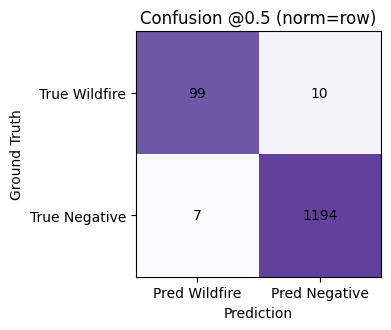

[Eval @1.000] ACC=0.9588 AUROC=0.9968 PR-AUC=0.9656


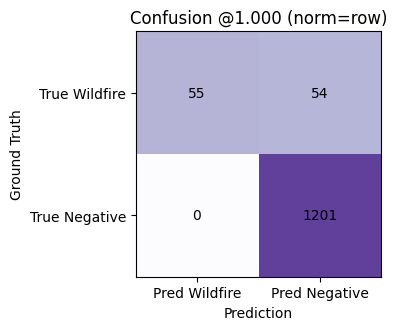

In [ ]:
#@title Teacher model Train and Test { vertical-output: true }

def find_threshold_for_precision(model, loader, target_precision:float=0.95):
    """
    Sweep thresholds to find the smallest threshold that achieves >= target precision.
    Returns (best_threshold, achieved_precision, recall_at_best).
    """
    model.eval()
    probs_all, y_all = [], []
    with torch.no_grad():
        for batch in loader:
            x, y = _iter_loader_yields_imgs_labels(batch)
            x = x.to(device)
            y = y.to(device).float()
            logits = model(x).view(-1)
            probs_all.append(sigmoid(logits).cpu())
            y_all.append(y.cpu())
    probs = torch.cat(probs_all).numpy()
    y     = torch.cat(y_all).numpy().astype(int)

    thresholds = np.linspace(0.0, 1.0, 501)
    best_t, best_prec, best_rec = 0.5, 0.0, 0.0
    for t in thresholds:
        pred = probs >= t
        tp = (pred & (y==1)).sum()
        fp = (pred & (y==0)).sum()
        fn = ((~pred) & (y==1)).sum()
        prec = tp / (tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp / (tp+fn) if (tp+fn)>0 else 0.0
        if prec >= target_precision:
            best_t, best_prec, best_rec = float(t), float(prec), float(rec)
            break
    return best_t, best_prec, best_rec

# === Train + test ===
teacher = train_teacher(teacher, train_loader, val_loader,
                        epochs_stage1=cfg.epochs_stage1,
                        epochs_stage2=cfg.epochs_stage2,
                        base_lr=cfg.lr,
                        weight_decay=cfg.weight_decay)

teacher_metrics, teacher_thresh, _ = test_models(teacher, test_loader)


In [ ]:
#@title Get teacher from file and
os.makedirs("teacher_models", exist_ok=True)
!cp TO BE FILLED IN teacher_models/.

[Teacher] params (trainable) = 87,567,489
Missing keys: []
Unexpected keys: []
Test model
[Eval @0.5] ACC=0.9733 AUROC=0.9962 PR-AUC=0.9584


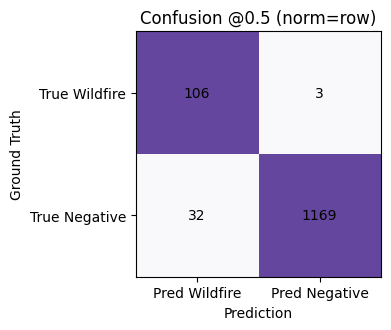

[Eval @1.000] ACC=0.9672 AUROC=0.9962 PR-AUC=0.9584


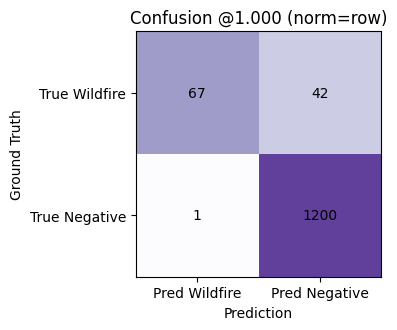

In [42]:
#@title Load teacher from file (skip retraining) { vertical-output: true }

best_path = str("teacher_models/teacher_128x128.pt")

teacher = TeacherModel()
print(f"[Teacher] params (trainable) = {count_trainable_params(teacher):,}")
teacher.to(device);

ckpt = torch.load(best_path, map_location=device)
state = ckpt["model"]

# state = ckpt.get('model', ckpt.get('state_dict', ckpt))
# from collections import OrderedDict
# if any(k.startswith('module.') for k in state.keys()):
#     state = OrderedDict((k.replace('module.', ''), v) for k, v in state.items())

missing, unexpected = teacher.load_state_dict(state, strict=False)  # strict=True if you expect exact match
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

print("Test model")
teacher_metrics, teacher_thresh, _ = test_models(teacher, test_loader)

In [43]:
#@title Student model: Original { vertical-output: true }
import math
import torch
import torch.nn as nn

# --- tiny utilities ---
def _round_channels(ch: int, mult: float, min_ch: int = 4, align: int = 2) -> int:
    sc = max(min_ch, int(round(ch * mult)))
    sc = max(min_ch, int(math.ceil(sc / align) * align))  # even alignment
    return sc

class ConvBNFree(nn.Module):
    def __init__(self, ci, co, k=3, s=1):
        super().__init__()
        p = k // 2
        self.conv = nn.Conv2d(ci, co, kernel_size=k, stride=s, padding=p, bias=True)
        self.act  = nn.ReLU(inplace=False)
    def forward(self, x):
        return self.act(self.conv(x))

class BasicBlock(nn.Module):
    """Two 3×3 convs with residual (BN-free)."""
    def __init__(self, ci, co, s=1):
        super().__init__()
        self.conv1 = ConvBNFree(ci, co, k=3, s=s)
        self.conv2 = ConvBNFree(co, co, k=3, s=1)
        self.use_proj = (s != 1) or (ci != co)
        self.proj = ConvBNFree(ci, co, k=1, s=s) if self.use_proj else None
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        if self.use_proj:
            x = self.proj(x)
        return y + x

class BottleneckBlock(nn.Module):
    """
    Param-efficient bottleneck: 1x1 reduce → 3x3 → 1x1 expand (BN-free).
    Keeps ops: conv/relu/add only.
    """
    def __init__(self, ci, co, s=1, bottleneck_ratio: float = 0.5):
        super().__init__()
        mid = max(4, int(round(co * bottleneck_ratio)))
        self.reduce = ConvBNFree(ci, mid, k=1, s=1)
        self.conv3  = ConvBNFree(mid, mid, k=3, s=s)
        self.expand = ConvBNFree(mid, co, k=1, s=1)
        self.use_proj = (s != 1) or (ci != co)
        self.proj = ConvBNFree(ci, co, k=1, s=s) if self.use_proj else None
    def forward(self, x):
        y = self.reduce(x)
        y = self.conv3(y)
        y = self.expand(y)
        if self.use_proj:
            x = self.proj(x)
        return y + x

class StudentBudgetNet(nn.Module):
    """
    Budgetable student for 64x64 RGB, single-logit output.
    Channels are scaled by width_mult. Depth is fixed but lightweight.
    """
    def __init__(self, img_size: int = 64, width_mult: float = 1.0,
                 use_bottleneck: bool = True, fc_scale: float = 1.0):
        super().__init__()
        # Baseline channels (match prior student topology)
        c_stem = _round_channels(16, width_mult)
        c2     = _round_channels(24, width_mult)
        c3     = _round_channels(32, width_mult)
        c4     = _round_channels(40, width_mult)

        Block = BottleneckBlock if use_bottleneck else BasicBlock

        # Stem
        self.stem1 = ConvBNFree(3,  c_stem, k=3, s=1)
        self.stem2 = ConvBNFree(c_stem, c_stem, k=3, s=2)  # /2

        # Stages (/4, /8, /16)
        self.s2  = Block(c_stem, c2, s=2)   # /4
        self.s2b = Block(c2,     c2, s=1)

        self.s3  = Block(c2, c3, s=2)       # /8
        self.s3b = Block(c3, c3, s=1)

        self.s4  = Block(c3, c4, s=2)       # /16
        self.s4b = Block(c4, c4, s=1)

        # Head
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        fc_mid = max(8, _round_channels(24, width_mult * fc_scale))
        self.fc1  = nn.Linear(c4, fc_mid, bias=True)
        self.act  = nn.ReLU(inplace=False)
        self.fc2  = nn.Linear(fc_mid, 1, bias=True)

    def forward(self, x):
        x = self.stem1(x); x = self.stem2(x)
        x = self.s2(x);    x = self.s2b(x)
        x = self.s3(x);    x = self.s3b(x)
        x = self.s4(x);    x = self.s4b(x)
        f = self.pool(x).flatten(1)
        z = self.fc1(f); z = self.act(z)
        out = self.fc2(z)
        return out

# --- budgeted builder with binary search on width_mult ---
def build_student_for_budget(max_param_count: int,
                             img_size: int = 64,
                             use_bottleneck: bool = True,
                             tol: float = 0.03,
                             fc_scale: float = 1.0,
                             device: torch.device | None = None) -> tuple[nn.Module, int, float]:
    """
    Find width_mult so that params <= max_param_count (within tol).
    Returns (model, n_params, width_mult_used).
    """
    dev = device or torch.device("cpu")

    # If full size already fits, return it
    full = StudentBudgetNet(img_size, width_mult=1.0, use_bottleneck=use_bottleneck, fc_scale=fc_scale)
    n_full = count_trainable_params(full)
    if n_full <= max_param_count:
        full.to(dev)
        print(f"[Budget] width_mult=1.00 fits: params={n_full:,} ≤ {max_param_count:,}")
        return full, n_full, 1.0

    # Binary search width in [lo, hi], monotonic in params (~width^2)
    lo, hi = 0.05, 1.00
    best_m, best_n = None, None
    for _ in range(28):  # ~1e-8 precision on width if needed
        mid = (lo + hi) * 0.5
        m = StudentBudgetNet(img_size, width_mult=mid, use_bottleneck=use_bottleneck, fc_scale=fc_scale)
        n = count_trainable_params(m)
        if n <= max_param_count:
            best_m, best_n = m, n
            lo = mid  # try bigger (more capacity)
        else:
            hi = mid  # need smaller
    if best_m is None:
        # Even the tiniest width failed; shrink head slightly and retry once
        fc_scale2 = 0.75
        print(f"[Budget] Even minimal width exceeded budget. Retrying with smaller head (fc_scale={fc_scale2}).")
        return build_student_for_budget(max_param_count, img_size, use_bottleneck, tol, fc_scale2, dev)

    width_mult_used = lo
    # If we’re far under budget, one step up (greedy nudge)
    for _ in range(4):
        trial_w = min(1.0, width_mult_used * 1.03)
        trial = StudentBudgetNet(img_size, width_mult=trial_w, use_bottleneck=use_bottleneck, fc_scale=fc_scale)
        trial_n = count_trainable_params(trial)
        if trial_n <= max_param_count:
            best_m, best_n, width_mult_used = trial, trial_n, trial_w
        else:
            break

    best_m.to(dev)
    gap = (max_param_count - best_n) / max_param_count
    print(f"[Budget] target={max_param_count:,}  got={best_n:,}  gap={gap*100:.1f}%  width_mult={width_mult_used:.3f}  "
          f"bottleneck={'on' if use_bottleneck else 'off'}")
    return best_m, best_n, width_mult_used


In [44]:
#@title Student model:  ReLU-only, no fancy activations or adaptive ops { vertical-output: true }
import math
import torch
import torch.nn as nn

# ---------- utils (reuse if already defined) ----------
def _round_channels(ch: int, mult: float, min_ch: int = 4, align: int = 2) -> int:
    sc = max(min_ch, int(round(ch * mult)))
    sc = max(min_ch, int(math.ceil(sc / align) * align))
    return sc

def count_trainable_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

class ConvReLU(nn.Module):
    def __init__(self, ci, co, k=3, s=1):
        super().__init__()
        p = k // 2
        self.conv = nn.Conv2d(ci, co, kernel_size=k, stride=s, padding=p, bias=True)
        self.act  = nn.ReLU(inplace=False)
    def forward(self, x):
        return self.act(self.conv(x))

class BasicBlock(nn.Module):
    def __init__(self, ci, co, s=1):
        super().__init__()
        self.conv1 = ConvReLU(ci, co, k=3, s=s)
        self.conv2 = ConvReLU(co, co, k=3, s=1)
        self.use_proj = (s != 1) or (ci != co)
        self.proj = ConvReLU(ci, co, k=1, s=s) if self.use_proj else None
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        if self.use_proj:
            x = self.proj(x)
        return y + x

class StudentReluOnly(nn.Module):
    """
    Same general depth as your original, but:
      - Only ReLU activations
      - No AdaptiveAvgPool (explicit mean instead)
      - No other nonlinearities (no SiLU/GELU/etc.)
    """
    def __init__(self, img_size: int = 64, width_mult: float = 1.0, fc_scale: float = 1.0):
        super().__init__()
        c_stem = _round_channels(16, width_mult)
        c2     = _round_channels(24, width_mult)
        c3     = _round_channels(32, width_mult)
        c4     = _round_channels(40, width_mult)

        # Stem (gentle downsample like your baseline)
        self.stem1 = ConvReLU(3,      c_stem, k=3, s=1)
        self.stem2 = ConvReLU(c_stem, c_stem, k=3, s=2)  # /2

        # Stages (/4, /8, /16) with BasicBlocks (ReLU-only)
        self.s2  = BasicBlock(c_stem, c2, s=2)   # /4
        self.s2b = BasicBlock(c2,     c2, s=1)

        self.s3  = BasicBlock(c2, c3, s=2)       # /8
        self.s3b = BasicBlock(c3, c3, s=1)

        self.s4  = BasicBlock(c3, c4, s=2)       # /16
        self.s4b = BasicBlock(c4, c4, s=1)

        # Head: explicit global mean (avoid AdaptiveAvgPool)
        fc_mid = max(8, _round_channels(24, width_mult * fc_scale))
        self.fc1 = nn.Linear(c4, fc_mid, bias=True)
        self.act = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(fc_mid, 1, bias=True)

    def forward(self, x):
        x = self.stem1(x); x = self.stem2(x)
        x = self.s2(x);    x = self.s2b(x)
        x = self.s3(x);    x = self.s3b(x)
        x = self.s4(x);    x = self.s4b(x)
        f = x.mean(dim=(-2, -1))      # channel-wise mean over H,W
        z = self.fc1(f); z = self.act(z)
        out = self.fc2(z)
        return out

def build_student_relu_for_budget(max_param_count: int,
                                  img_size: int = 64,
                                  tol: float = 0.03,
                                  fc_scale: float = 1.0,
                                  device: torch.device | None = None):
    dev = device or torch.device("cpu")
    def make(w):
        return StudentReluOnly(img_size, width_mult=w, fc_scale=fc_scale)
    full = make(1.0)
    n_full = count_trainable_params(full)
    if n_full <= max_param_count:
        full.to(dev)
        print(f"[Budget/ReLU] width_mult=1.00 fits: params={n_full:,} ≤ {max_param_count:,}")
        return full, n_full, 1.0

    lo, hi = 0.05, 1.00
    best_m, best_n = None, None
    for _ in range(28):
        mid = 0.5 * (lo + hi)
        m = make(mid)
        n = count_trainable_params(m)
        if n <= max_param_count:
            best_m, best_n = m, n
            lo = mid
        else:
            hi = mid

    if best_m is None:
        fc_scale2 = 0.75
        print(f"[Budget/ReLU] Minimal width exceeded budget. Retrying with smaller head (fc_scale={fc_scale2}).")
        return build_student_relu_for_budget(max_param_count, img_size, tol, fc_scale2, dev)

    width_mult_used = lo
    for _ in range(6):
        trial_w = min(1.0, width_mult_used * 1.03)
        trial = make(trial_w)
        trial_n = count_trainable_params(trial)
        if trial_n <= max_param_count:
            best_m, best_n, width_mult_used = trial, trial_n, trial_w
        else:
            break

    best_m.to(dev)
    gap = (max_param_count - best_n) / max_param_count
    print(f"[Budget/ReLU] target={max_param_count:,}  got={best_n:,}  gap={gap*100:.1f}%  width_mult={width_mult_used:.3f}")
    return best_m, best_n, width_mult_used


In [45]:
#@title Student model:  Early-downsampled student (more stride/pooling up front) { vertical-output: true }
import math
import torch
import torch.nn as nn

# ---------- utils ----------
def _round_channels(ch: int, mult: float, min_ch: int = 4, align: int = 2) -> int:
    sc = max(min_ch, int(round(ch * mult)))
    sc = max(min_ch, int(math.ceil(sc / align) * align))  # even alignment
    return sc

def count_trainable_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

class ConvReLU(nn.Module):
    def __init__(self, ci, co, k=3, s=1):
        super().__init__()
        p = k // 2
        self.conv = nn.Conv2d(ci, co, kernel_size=k, stride=s, padding=p, bias=True)
        self.act  = nn.ReLU(inplace=False)
    def forward(self, x):
        return self.act(self.conv(x))

class BasicBlock(nn.Module):
    """Two 3×3 convs + residual (BN-free, ReLU only)."""
    def __init__(self, ci, co, s=1):
        super().__init__()
        self.conv1 = ConvReLU(ci, co, k=3, s=s)
        self.conv2 = ConvReLU(co, co, k=3, s=1)
        self.use_proj = (s != 1) or (ci != co)
        self.proj = ConvReLU(ci, co, k=1, s=s) if self.use_proj else None
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        if self.use_proj:
            x = self.proj(x)
        return y + x

class StudentEarlyDownsample(nn.Module):
    """
    Early-downsampled student for 64x64 RGB, single-logit output.
    Strategy:
      - Stem: /2 then /4 immediately (+ optional pool to /8)
      - Stages then mostly stride=1, keeping later activations tiny
    """
    def __init__(self, img_size: int = 64, width_mult: float = 1.0,
                 pool_to_8: bool = True, fc_scale: float = 1.0):
        super().__init__()
        # Channel plan (kept modest; width-scaled)
        c_stem = _round_channels(16, width_mult)
        c2     = _round_channels(24, width_mult)
        c3     = _round_channels(32, width_mult)
        c4     = _round_channels(40, width_mult)

        # Stem: 3x3 s=2 (/2) → 3x3 s=2 (/4)
        self.stem1 = ConvReLU(3,      c_stem, k=3, s=2)  # 64→32
        self.stem2 = ConvReLU(c_stem, c_stem, k=3, s=2)  # 32→16

        # Optional: 3x3 avg pool s=2 to go /8 very early (16→8)
        self.early_pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1) if pool_to_8 else nn.Identity()

        # Stages: mostly stride 1 now that we’re small
        # shapes if pool_to_8=True: after stem+pool -> H=W=8
        self.s2  = BasicBlock(c_stem, c2, s=1)   # keep 8×8
        self.s2b = BasicBlock(c2,     c2, s=1)

        # One more downsample late (8→4) to keep head tiny
        self.s3  = BasicBlock(c2, c3, s=2)       # /2 → 4×4
        self.s3b = BasicBlock(c3, c3, s=1)

        # Final stage at 4×4 (no further downsample)
        self.s4  = BasicBlock(c3, c4, s=1)
        self.s4b = BasicBlock(c4, c4, s=1)

        # Head: replace AdaptiveAvgPool with explicit channel-wise mean (EZKL-friendly)
        fc_mid = max(8, _round_channels(24, width_mult * fc_scale))
        self.fc1 = nn.Linear(c4, fc_mid, bias=True)
        self.act = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(fc_mid, 1, bias=True)

    def forward(self, x):
        x = self.stem1(x); x = self.stem2(x)
        x = self.early_pool(x)
        x = self.s2(x);    x = self.s2b(x)
        x = self.s3(x);    x = self.s3b(x)
        x = self.s4(x);    x = self.s4b(x)
        # Global mean over H,W (explicit, avoids AdaptiveAvgPool)
        f = x.mean(dim=(-2, -1))
        z = self.fc1(f); z = self.act(z)
        out = self.fc2(z)
        return out


# --- budgeted builder (unchanged interface) ---
def build_student_early_for_budget(max_param_count: int,
                                   img_size: int = 64,
                                   pool_to_8: bool = True,
                                   tol: float = 0.03,
                                   fc_scale: float = 1.0,
                                   device: torch.device | None = None):
    dev = device or torch.device("cpu")
    def make(w):
        return StudentEarlyDownsample(img_size, width_mult=w, pool_to_8=pool_to_8, fc_scale=fc_scale)
    full = make(1.0)
    n_full = count_trainable_params(full)
    if n_full <= max_param_count:
        full.to(dev)
        print(f"[Budget/Early] width_mult=1.00 fits: params={n_full:,} ≤ {max_param_count:,}")
        return full, n_full, 1.0

    lo, hi = 0.05, 1.00
    best_m, best_n = None, None
    for _ in range(28):
        mid = 0.5 * (lo + hi)
        m = make(mid)
        n = count_trainable_params(m)
        if n <= max_param_count:
            best_m, best_n = m, n
            lo = mid
        else:
            hi = mid
    if best_m is None:
        fc_scale2 = 0.75
        print(f"[Budget/Early] Minimal width exceeded budget. Retrying with smaller head (fc_scale={fc_scale2}).")
        return build_student_early_for_budget(max_param_count, img_size, pool_to_8, tol, fc_scale2, dev)

    width_mult_used = lo
    for _ in range(4):
        trial_w = min(1.0, width_mult_used * 1.03)
        trial = make(trial_w)
        trial_n = count_trainable_params(trial)
        if trial_n <= max_param_count:
            best_m, best_n, width_mult_used = trial, trial_n, trial_w
        else:
            break

    best_m.to(dev)
    gap = (max_param_count - best_n) / max_param_count
    print(f"[Budget/Early] target={max_param_count:,}  got={best_n:,}  gap={gap*100:.1f}%  width_mult={width_mult_used:.3f}")
    return best_m, best_n, width_mult_used


In [46]:
#@title Student model:  ReLU-only and Early-downsampled student { vertical-output: true }

import math
import torch
import torch.nn as nn

# --------- utils ----------
def _round_channels(ch: int, mult: float, min_ch: int = 4, align: int = 2) -> int:
    sc = max(min_ch, int(round(ch * mult)))
    sc = max(min_ch, int(math.ceil(sc / align) * align))
    return sc

def count_trainable_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

class ConvReLU(nn.Module):
    """Conv2d (bias=True) + ReLU (no in-place)."""
    def __init__(self, ci, co, k=3, s=1):
        super().__init__()
        p = k // 2
        self.conv = nn.Conv2d(ci, co, kernel_size=k, stride=s, padding=p, bias=True)
        self.act  = nn.ReLU(inplace=False)
    def forward(self, x):
        return self.act(self.conv(x))

class BasicBlockReLU(nn.Module):
    """Two 3×3 ConvReLU with residual; optional 1×1 projection when shape/stride changes."""
    def __init__(self, ci, co, s=1):
        super().__init__()
        self.conv1 = ConvReLU(ci, co, k=3, s=s)
        self.conv2 = ConvReLU(co, co, k=3, s=1)
        self.use_proj = (s != 1) or (ci != co)
        self.proj = ConvReLU(ci, co, k=1, s=s) if self.use_proj else None
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        if self.use_proj:
            x = self.proj(x)
        return y + x

# --------- combined model: early downsample + ReLU-only ----------
class StudentEarlyReLU(nn.Module):
    """
    64x64 RGB -> 1 logit.
    - Early downsampling: /2, /4, and optional /8 in the stem via AvgPool.
    - Only ReLU nonlinearities; no adaptive ops (explicit channel-wise mean).
    - Residual basic blocks.
    """
    def __init__(self, img_size: int = 64, width_mult: float = 1.0,
                 pool_to_8: bool = True, fc_scale: float = 1.0):
        super().__init__()
        # Channel plan (width-scaled, even-aligned)
        c_stem = _round_channels(16, width_mult)
        c2     = _round_channels(24, width_mult)
        c3     = _round_channels(32, width_mult)
        c4     = _round_channels(40, width_mult)

        # Stem: strong early downsample
        self.stem1 = ConvReLU(3,      c_stem, k=3, s=2)  # 64 -> 32
        self.stem2 = ConvReLU(c_stem, c_stem, k=3, s=2)  # 32 -> 16
        self.early_pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1) if pool_to_8 else nn.Identity()  # 16 -> 8

        # Stage @ ~8x8
        self.s2  = BasicBlockReLU(c_stem, c2, s=1)
        self.s2b = BasicBlockReLU(c2,     c2, s=1)

        # Downsample once more to 4x4
        self.s3  = BasicBlockReLU(c2, c3, s=2)  # 8 -> 4
        self.s3b = BasicBlockReLU(c3, c3, s=1)

        # Final stage stays at 4x4
        self.s4  = BasicBlockReLU(c3, c4, s=1)
        self.s4b = BasicBlockReLU(c4, c4, s=1)

        # Head: explicit global mean over H,W (no AdaptiveAvgPool)
        fc_mid = max(8, _round_channels(24, width_mult * fc_scale))
        self.fc1 = nn.Linear(c4, fc_mid, bias=True)
        self.act = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(fc_mid, 1, bias=True)

    def forward(self, x):
        x = self.stem1(x); x = self.stem2(x)
        x = self.early_pool(x)
        x = self.s2(x);    x = self.s2b(x)
        x = self.s3(x);    x = self.s3b(x)
        x = self.s4(x);    x = self.s4b(x)
        f = x.mean(dim=(-2, -1))      # channel-wise mean
        z = self.fc1(f); z = self.act(z)
        out = self.fc2(z)
        return out

# --------- budgeted builder ----------
def build_student_early_relu_for_budget(max_param_count: int,
                                        img_size: int = 64,
                                        pool_to_8: bool = True,
                                        fc_scale: float = 1.0,
                                        device: torch.device | None = None):
    """
    Binary-search width_mult to stay within param budget.
    Returns (model, n_params, width_mult_used).
    """
    dev = device or torch.device("cpu")
    def make(w):
        return StudentEarlyReLU(img_size, width_mult=w, pool_to_8=pool_to_8, fc_scale=fc_scale)

    full = make(1.0)
    n_full = count_trainable_params(full)
    if n_full <= max_param_count:
        full.to(dev)
        print(f"[Budget/EarlyReLU] width_mult=1.00 fits: params={n_full:,} ≤ {max_param_count:,}")
        return full, n_full, 1.0

    lo, hi = 0.05, 1.00
    best_m, best_n = None, None
    for _ in range(28):
        mid = 0.5 * (lo + hi)
        m = make(mid)
        n = count_trainable_params(m)
        if n <= max_param_count:
            best_m, best_n = m, n
            lo = mid
        else:
            hi = mid

    if best_m is None:
        fc_scale2 = 0.75
        print(f"[Budget/EarlyReLU] Minimal width exceeded budget. Retrying with smaller head (fc_scale={fc_scale2}).")
        return build_student_early_relu_for_budget(max_param_count, img_size, pool_to_8, fc_scale2, dev)

    width_mult_used = lo
    for _ in range(4):
        trial_w = min(1.0, width_mult_used * 1.03)
        trial = make(trial_w)
        trial_n = count_trainable_params(trial)
        if trial_n <= max_param_count:
            best_m, best_n, width_mult_used = trial, trial_n, trial_w
        else:
            break

    best_m.to(dev)
    gap = (max_param_count - best_n) / max_param_count
    print(f"[Budget/EarlyReLU] target={max_param_count:,}  got={best_n:,}  gap={gap*100:.1f}%  width_mult={width_mult_used:.3f}")
    return best_m, best_n, width_mult_used


In [18]:
#@title Install onnx { vertical-output: true }
!pip install -q onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 108.3 MB/s eta 0:00:00



##########################################
Run sim for 5000 parameters
##########################################

[Budget/Early] target=5,000  got=4,423  gap=11.5%  width_mult=0.187
Student params: 4,423, width_mult=0.187

Start Distillation Training from Teacher
[KD][1/40] loss=7.8545 soft=10.8995 hard=0.7494 VAL_ACC=0.0833 AUROC=0.7225 PR-AUC=0.2184
[KD][2/40] loss=7.1859 soft=9.9173 hard=0.8128 VAL_ACC=0.4917 AUROC=0.8905 PR-AUC=0.4253
[KD][3/40] loss=6.0225 soft=8.2531 hard=0.8179 VAL_ACC=0.7325 AUROC=0.9139 PR-AUC=0.4685
[KD][4/40] loss=5.1407 soft=6.9954 hard=0.8131 VAL_ACC=0.7533 AUROC=0.9218 PR-AUC=0.5139
[KD][5/40] loss=5.0526 soft=6.8845 hard=0.7780 VAL_ACC=0.6908 AUROC=0.9251 PR-AUC=0.4881
[KD][6/40] loss=4.9002 soft=6.6662 hard=0.7795 VAL_ACC=0.6958 AUROC=0.9269 PR-AUC=0.5275
[KD][7/40] loss=4.9883 soft=6.7803 hard=0.8067 VAL_ACC=0.7600 AUROC=0.9349 PR-AUC=0.5458
[KD][8/40] loss=4.8241 soft=6.5583 hard=0.7776 VAL_ACC=0.7267 AUROC=0.9338 PR-AUC=0.5468
[KD][9/40] loss=4.784

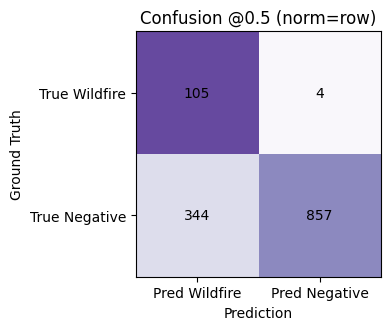

[Eval @1.000] ACC=0.9168 AUROC=0.9173 PR-AUC=0.4327


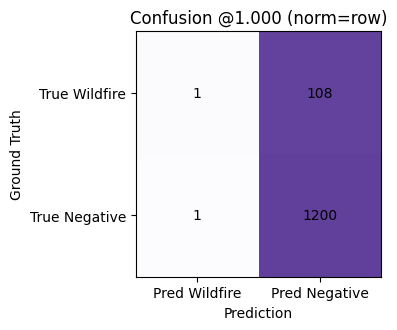


[ONNX] Exported EZKL-safe student to: /content/checkpoints/students/128x128_5000_params.onnx


/tmp/ipython-input-4249108267.py:167: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


In [ ]:
#@title Student model training through distillation → then dataset training { vertical-output: true }

from dataclasses import dataclass

@dataclass
class KDConfig:
    temperature: float = 4.0
    alpha: float = 0.7          # weight on soft loss
    epochs: int = 5
    lr: float = 5e-4
    weight_decay: float = 0.0

@dataclass
class StudentSupConfig:
    epochs: int = 10
    lr: float = 5e-4
    weight_decay: float = 1e-4

def kd_train(student: nn.Module, teacher: nn.Module, train_loader, val_loader, kd_cfg: KDConfig):
    teacher.eval().to(device)
    for p in teacher.parameters(): p.requires_grad = False

    json_save = {
        "epoch": [],
        "loss": [],
        "soft": [],
        "hard": [],
        "val_acc": [],
        "auroc": [],
        "ap": []
    }

    student.train().to(device)
    opt = AdamW(student.parameters(), lr=kd_cfg.lr, weight_decay=kd_cfg.weight_decay)
    scaler = GradScaler("cuda", enabled=torch.cuda.is_available())

    def kd_loss(s_logits, t_logits, y):
        T = kd_cfg.temperature
        t_prob = torch.sigmoid(t_logits / T).detach()
        soft = F.binary_cross_entropy_with_logits(s_logits / T, t_prob, reduction='mean') * (T*T)
        hard = F.binary_cross_entropy_with_logits(s_logits, y.float(), reduction='mean')
        return kd_cfg.alpha * soft + (1 - kd_cfg.alpha) * hard, soft.item(), hard.item()

    for e in range(1, kd_cfg.epochs+1):
        running, soft_sum, hard_sum, n = 0.0, 0.0, 0.0, 0
        for batch in train_loader:
            x, y = _iter_loader_yields_imgs_labels(batch)
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with autocast("cuda", enabled=torch.cuda.is_available()):
                t_logits = teacher(x).view(-1)
                s_logits = student(x).view(-1)
                loss, s_part, h_part = kd_loss(s_logits, t_logits, y)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            scaler.step(opt); scaler.update()
            bs = x.size(0)
            running += loss.item()*bs; soft_sum += s_part*bs; hard_sum += h_part*bs; n += bs
        val = evaluate_bce_logits(student, val_loader)
        print(f"[KD][{e}/{kd_cfg.epochs}] loss={running/max(1,n):.4f} soft={soft_sum/max(1,n):.4f} hard={hard_sum/max(1,n):.4f} "
              f"VAL_ACC={val['acc']:.4f} AUROC={val['auroc']:.4f} PR-AUC={val['ap']:.4f}")
        json_save["epoch"].append(e)
        json_save["loss"].append(running/max(1,n))
        json_save["soft"].append(soft_sum/max(1,n))
        json_save["hard"].append(hard_sum/max(1,n))
        json_save["val_acc"].append(val['acc'])
        json_save["auroc"].append(val['auroc'])
        json_save["ap"].append(val['ap'])

    return json_save

def supervise_student(student: nn.Module, train_loader, val_loader, sup_cfg: StudentSupConfig):
    student.train().to(device)
    pos_weight = compute_pos_weight_from_counts(pos_cnt, neg_cnt)
    criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    opt = AdamW(student.parameters(), lr=sup_cfg.lr, weight_decay=sup_cfg.weight_decay)
    scaler = GradScaler(enabled=torch.cuda.is_available())

    for e in range(1, sup_cfg.epochs+1):
        running, n = 0.0, 0
        for batch in train_loader:
            x, y = _iter_loader_yields_imgs_labels(batch)
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).float()
            opt.zero_grad(set_to_none=True)
            with autocast("cuda", enabled=torch.cuda.is_available()):
                logits = student(x).view(-1)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            scaler.step(opt); scaler.update()
            running += loss.item()*x.size(0); n += x.size(0)
        val = evaluate_bce_logits(student, val_loader)
        print(f"[StudentSup][{e}/{sup_cfg.epochs}] loss={running/max(1,n):.4f} "
              f"VAL_ACC={val['acc']:.4f} AUROC={val['auroc']:.4f} PR-AUC={val['ap']:.4f}")

import json

# Input
def load_json(file_name):
    with open(file_name) as f:
        output = json.load(f)
    return output

# Output
def save_json(file_name, data):
    with open(file_name,'w') as f:
        json.dump(data, f)

# Build student

os.makedirs("checkpoints/students", exist_ok=True)

for param_count_set in [5_000]:

    print()
    print("##########################################")
    print("Run sim for", param_count_set, "parameters")
    print("##########################################")
    print()

    # student, n_params, w_used = build_student_for_budget(
    #     max_param_count=param_count_set,
    #     img_size=cfg.img_size,
    #     use_bottleneck=True,
    #     device=device
    # )


    # student, n_params, w_used = build_student_early_relu_for_budget(
    # student, n_params, w_used = build_student_relu_for_budget(
    student, n_params, w_used = build_student_early_for_budget(
        max_param_count=param_count_set,
        img_size=cfg.img_size,
        device=device
    )

    print(f"Student params: {n_params:,}, width_mult={w_used:.3f}")
    print()

    # === Distill then supervise ===
    kd_cfg  = KDConfig(temperature=4.0, alpha=0.7, epochs=40, lr=5e-4, weight_decay=0.0)
    sup_cfg = StudentSupConfig(epochs=10, lr=5e-4, weight_decay=1e-4)

    print("Start Distillation Training from Teacher")
    json_save = kd_train(student, teacher, train_loader, val_loader, kd_cfg)
    print()
    # print("Start Supervised Training on dataset")
    # supervise_student(student, train_loader, val_loader, sup_cfg)

    print()
    print("Test on test dataset")
    student_metrics, student_thresh, _ = test_models(student, test_loader)  # reuse same helpers
    print()

    from pathlib import Path

    file_name_onnx = "128x128_"+str(param_count_set)+"_params.onnx"
    file_name_json = "128x128_"+str(param_count_set)+"_params.json"

    onnx_path = Path(cfg.out_dir) / "students" / file_name_onnx

    student_eval = student.eval().to("cpu").float()

    dummy = torch.zeros(1, 3, cfg.img_size, cfg.img_size, dtype=torch.float32)
    torch.onnx.export(
        student_eval,
        dummy,
        str(onnx_path),
        opset_version=13,
        input_names=["input"],
        output_names=["logit"],
        dynamic_axes=None,            # fixed shape is best for ezkl tracing
        do_constant_folding=True
    )
    print(f"[ONNX] Exported EZKL-safe student to: {onnx_path}")

    json_path = Path(cfg.out_dir) / "students" / file_name_json
    save_json(json_path, json_save)

    !cp checkpoints/students/* TO BE FILLED IN